In [333]:
%pylab inline
import numpy as np
import random
import scipy
from statsmodels.stats import weightstats

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Statistics made simple through simulation

## The 5 Step Modeling Approach

1. Ask the question
2. Select the modeling approach
3. Formulate the model
4. Solve the model
5. Answer the question


## Monte Carlo Simulation

Pros
* General method that can give approximate solutions to any probability modeling problem. (Mathematical Modeling, Meerschaert)
* Intuitive models that are fairly straight-forward to grasp without much mathematical formalism.

Cons
* Solves via brute force and that can get very time intensive.
* The simulation itself introduces extra variation into your solution

To the last point while this is true, Meerschaert says:

"As a practical matter, there are many sources of error and variation in a modeling problem, and the additional variation produced by Monte Carlo simulation is not typically the most serious of these."

He goes on to say that sensitivity analysis is your friend.

We'll be using this term to be synonomous with Analytical Simulation. The core difference is a pure Monte Carlo simulation works in simplest terms with no higher level mathematical concepts. An analytical simulation may use probability distributions or other mathematical tooling as a shortcut.

## Enough theory

Easiest to explain with a simple example. Suppose you're in a room facing a large wall and large open window with a bowl full of marbles on a table behind you. 

How might you answer the question: "What percentage of that wall is the window taking up?"

Process
1. Count how many marbles are in the bowl.
2. Close your eyes and throw marbles at the wall in a purely random way.
3. Find the percentage of marbles that went through the window.

The answer you get from step 3 will approximate how much of the wall the window takes up.

Let's simulate this and see how it works.

In [41]:
wall_width = 20
wall_height = 10

window_lower_left = (5, 2.5)
window_upper_right = (15, 7.5)

number_of_marbles = 1000

sample_widths = np.random.random(number_of_marbles) * wall_width
sample_heights = np.random.random(number_of_marbles) * wall_height

random_marbles_thrown = zip(sample_widths, sample_heights)

We pick an X and a Y to form a coordinate that we throw a marble at. We throw all of our marbles this way. Then we gather all of the marbles that hit the wall and didn't go through the window.

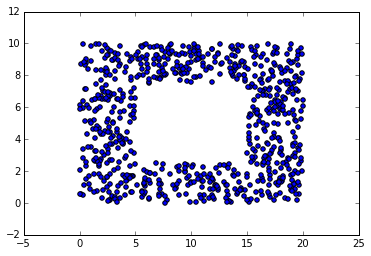

In [42]:
marbles_that_hit_the_wall = filter(lambda x: (x[0] < window_lower_left[0] or x[0] > window_upper_right[0]) or
                                            (x[1] < window_lower_left[1] or x[1] > window_upper_right[1]), 
                                  random_marbles_thrown)

plt.scatter(x=map(lambda x: x[0], marbles_that_hit_the_wall), y=map(lambda x: x[1], marbles_that_hit_the_wall))

Next we find the percentage of marbles that went through the window to find what percentage of the wall the window takes up.

In [45]:
len(marbles_that_hit_the_wall) / (1.0*number_of_marbles)

0.749

In [49]:
1 - len(marbles_that_hit_the_wall) / (1.0*number_of_marbles)

0.251

## FACT CHECK

It's pretty straight forward to do this manually with math.

In [48]:
(10 * 5) / (1.0 * wall_height * wall_width)

0.25

## Simulating integration of an arbitrary function

The same technique works when trying to evaluate a definite integral. Let's use a normal curve and find out how much area of the curve is between -1 and 1. Or in other words, within one standard deviation. Given what we've learned in stats 101 we would expect the answer to be ~0.682.

In [75]:
def normal(x):
    standard_deviation = 1.0
    mean = 0.0
    return np.exp(-((x-mean)**2)/(2.0 * standard_deviation)) / np.sqrt(2*np.pi)

In [86]:
max_value = normal(0)
x_values = np.random.random(5000) * 2.0 - 1 # Generate x values between -1 and 1.
y_values = np.random.random(5000) * max_value

points = zip(x_values, y_values)
points_under_curve = filter(lambda x: x[1] <= normal(x[0]) , 
                                  points)

print(2.0 * max_value * len(points_under_curve) / (1.0 * len(points)))

0.680116799628


+/- a standard deviation is ~68.2% of the area by the way. Our approximation comes very close.

And hey let's graph this for good measure. This is the region that is under the curve of our function.

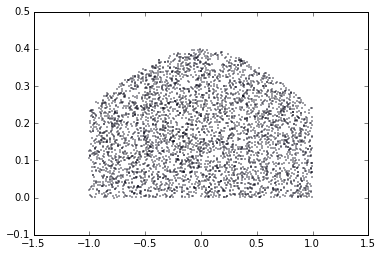

In [89]:
plt.scatter(x=map(lambda x: x[0], points_under_curve), y=map(lambda y: y[1], points_under_curve), s=0.2)

The basic idea is to form a rectangular window around the function you want to integrate, randomly place points in the window, then see what percent are below your curve. After this, you can multiply the known area of the rectangle with the percentage of the points that were under your curve to get your answer.

## Key Moral: Simulation empowers us to explore statistics and probability instead of consulting an oracle.

## Statistical tests that make no (read: fewer) assumptions

Let's say we have two samples of data and we want to know how likely it is that the mean of the population of sample A is greater than the mean of the population of sample B. Let's not T-test. Let's choose an even more flexible test- bootstrapping.

''

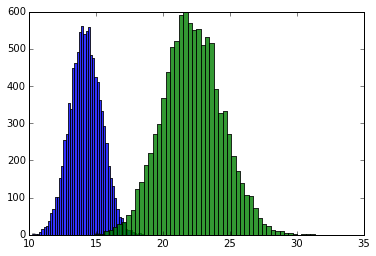

In [123]:
sample_a = np.random.gamma(3.5, 5, 40)
sample_b = np.random.gamma(4.5, 5, 20)

sample_a_samples = [np.random.choice(sample_a, 40).mean() for i in range(10000)]
sample_b_samples = [np.random.choice(sample_b, 20).mean() for i in range(10000)]

plt.hist(sample_a_samples, bins=50, alpha=.8)
plt.hist(sample_b_samples, bins=50, alpha=.8)
''

Key take aways here: We've come up with a distribution of possible population means by resampling from observed data.

''

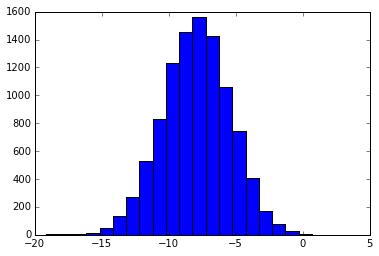

In [124]:
random_pairings = zip(sample_a_samples, sample_b_samples)
difference_of_pairings = map(lambda x: x[0] - x[1], random_pairings)

plt.hist(difference_of_pairings, bins=20)
''

In [114]:
difference_of_pairings = sorted(difference_of_pairings)
print('95% Credible region: {0} to {1}'.format(difference_of_pairings[25], difference_of_pairings[-25]))

95% Credible region: -13.1169462263 to -3.10525291921


There is 95% probability that the true value lies in the above range. So there is evidence that the population of sample_a has an average that is lower.

## Parametric Tests

Now let's say we want to determine if a coin is fair. We can solve this using bootstrapping or by using a parametric distribution. First we'll start with the bootstrapping approach.

''

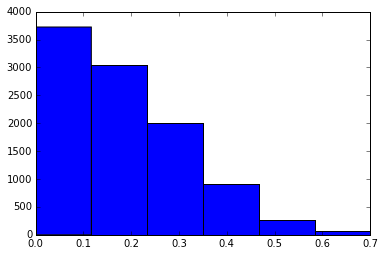

In [132]:
sample_coin_flips = [0,0,0,0,1,1,0,0,0,0]
sample_coin_flip_averages = [np.random.choice(sample_coin_flips, len(sample_coin_flips)).mean() for i in range(10000)]
plt.hist(sample_coin_flip_averages, bins=6)
''

''

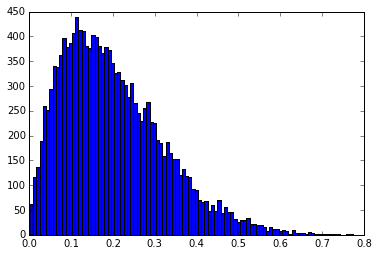

In [140]:
possibilities = [np.random.beta(sum(sample_coin_flips), 10-sum(sample_coin_flips)) for i in range(15000)]
plt.hist(possibilities, bins=100)
''

''

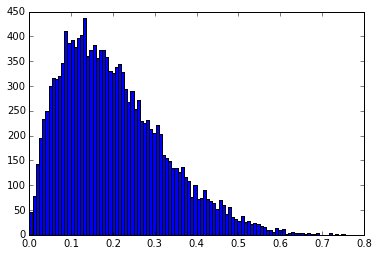

In [156]:
coin_flip_values = [0,1]
sample_coin_flips = [8,2]
sample_coin_flip_averages = [(np.random.dirichlet(sample_coin_flips) * coin_flip_values).sum() for i in range(15000)]
plt.hist(sample_coin_flip_averages, bins=100)
''

In [152]:
(np.random.dirichlet(sample_coin_flips) * coin_flip_values).sum()

0.0312727360328348

## Split Test Conversion

What can we say about the below split test? Also a great opportunity to explore the affects of sample size on test results.

''

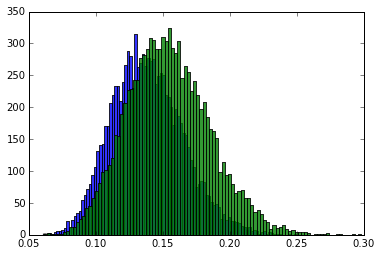

In [171]:
variant_a_orders = 23
variant_a_visits = 144

variant_b_orders = 21
variant_b_visits = 115

variant_a_samples = [np.random.beta(variant_a_orders, variant_a_visits) for i in range(10000)]
variant_b_samples = [np.random.beta(variant_b_orders, variant_b_visits) for i in range(10000)]

plt.hist(variant_a_samples, bins=100, alpha=.8)
plt.hist(variant_b_samples, bins=100, alpha=.8)
''

95% chance the true change is between -0.135451127774% points and 0.0934575475419% points.


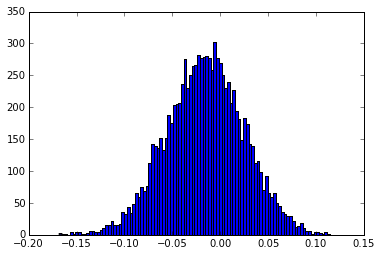

In [172]:
variant_a_improvement = sorted(map(lambda x: x[0] - x[1], zip(variant_a_samples, variant_b_samples)))

plt.hist(variant_a_improvement, bins = 100)
print('95% chance the true change is between {0}% points and {1}% points.'.format(variant_a_improvement[25], variant_a_improvement[-25]))

## Exploring unintuitive probability puzzles

Monty Hall is a classic example. You're probably familiar but I'll repeat. 

Scenario:

You're asked to choose one of three doors in order to win a car that's behind one of them. After you pick a door, the game show host opens one door that is not a winner (it has a goat behind it) and then asks if you want to switch your door and stick with the one you chose.

What's the optimal strategy to win the car? Stick or switch? Spoiler Alert! You want to switch. Does that seem crazy?

Let's simulate both strategies and see which is better.

In [203]:
def simulate_game(switch = True, iteration_count = 1000):
  wins = 0
  for i in range(iteration_count):
    prizes = ['goat','car','goat']
    random.shuffle(prizes)
    doors = {
        1: prizes[0],
        2: prizes[1],
        3: prizes[2]
    }
    chosen_door = np.random.choice([1,2,3])
    
    # Host chooses which door to open
    for key, value in doors.iteritems():
        if key != chosen_door and doors[key] != 'car':
            del doors[key]
            break
    
    # Does the contestant switch or stick??
    if switch:
        for key, value in doors.iteritems():
            if key != chosen_door:
                chosen_door = key
                break
    
    if doors[chosen_door] == 'car':
        wins += 1
  return wins

print('Games won with switching strategy: {0}'.format(simulate_game(switch = True, iteration_count=10000)))
print('Games won with sticking strategy: {0}'.format(simulate_game(switch = False, iteration_count=10000)))

Games won with switching strategy: 6713
Games won with sticking strategy: 3388


## Continuing our statistical exploration

How do we calculate sample size? I bet the answer is math isn't it? Nope. Simulation. Here's how.

''

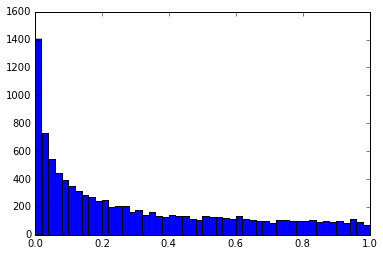

In [230]:
p_values = []

for i in range(10000):
    control = np.random.normal(1.2,1,80)
    variant = np.random.normal(1.0,1,80)
    t_stat, p_value, df = statsmodels.stats.weightstats.ttest_ind(control, variant, alternative='two-sided')
    p_values.append(p_value)

plt.hist(p_values, bins=50)
''

Let's look at power of our test as a function of sample size again using simulation.


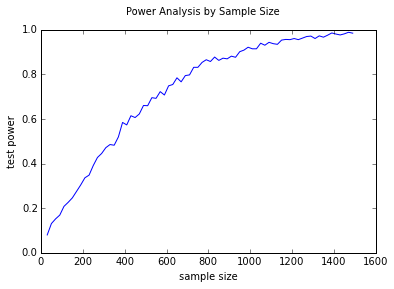

In [249]:
percentage_of_runs_correct = []
sample_sizes = list(xrange(30, 1500, 20))
for sample_size in xrange(30, 1500, 20):
    correct_test = 0
    runs = 1000
    for i in range(runs):
        control = np.random.normal(1.15,1,sample_size)
        variant = np.random.normal(1.0,1,sample_size)
        t_stat, p_value, df = statsmodels.stats.weightstats.ttest_ind(control, variant, alternative='two-sided')
        if p_value <= 0.05:
            correct_test += 1
    percentage_of_runs_correct.append(correct_test/(1.0*runs))
    
fig = plt.figure()
fig.suptitle('Power Analysis by Sample Size')
plt.xlabel('sample size')
plt.ylabel('test power')
plt.plot(sample_sizes, percentage_of_runs_correct)

Now you can play with different factors in your experiment and tangibly see how they affect your experiment design.

How about asking a question like: How does the conversion rate of our population affect our ability to detect improvements?

''

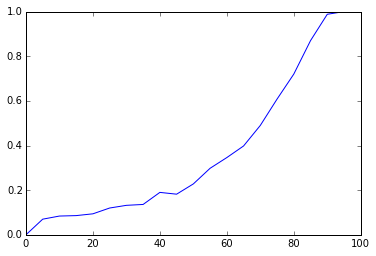

In [279]:
p_values = []
success_rates = []
population_rates = list(xrange(0,100,5))

for population_rate in population_rates:
    sims_to_run = 500
    number_of_trials = 1000
    total_success = 0
    successes = np.random.binomial(number_of_trials, 1.04 * population_rate/100., sims_to_run)
    for success in successes:
        p_value = scipy.stats.binom_test(success, number_of_trials, population_rate/100.)
        p_values.append(p_value)
        if p_value <= 0.05:
            total_success += 1
    success_rates.append(total_success/(1.0*sims_to_run))
plt.plot(population_rates, success_rates)
''

What if instead of using a percentage lift we used percentage points?

''

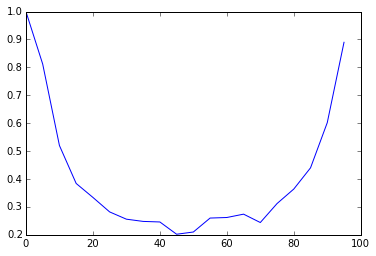

In [282]:
p_values = []
success_rates = []
population_rates = list(xrange(0,100,5))

for population_rate in population_rates:
    sims_to_run = 500
    number_of_trials = 1000
    total_success = 0
    successes = np.random.binomial(number_of_trials, 0.02 + population_rate/100., sims_to_run)
    for success in successes:
        p_value = scipy.stats.binom_test(success, number_of_trials, population_rate/100.)
        p_values.append(p_value)
        if p_value <= 0.05:
            total_success += 1
    success_rates.append(total_success/(1.0*sims_to_run))
plt.plot(population_rates, success_rates)
''

Why? The variance is higher in the middle. The left and right edges are more consistent so a deviation from that consistency is easier to detect.

## Extra Credit: Touching on Bayesian Statistics

We can use some of these ideas along with probability to tackle problems with non-obvious solutions.

You're given 5 dice (d6, d8, d12, d20, d22). One of these die are rolled (but you don't know which). You're told it rolled a 7, what's the probability the die is 8-sided?

First, we call out our hypotheses and make sure they add up to 100%.

In [319]:
hypotheses = {
    6: 1,
    8: 1,
    12:1,
    20:1,
    22:1
}

# Normalize
total_possibilities = sum(hypotheses.values())
for key, value in hypotheses.iteritems():
    hypotheses[key] = hypotheses[key]/(1.0*total_possibilities)

hypotheses

{6: 0.2, 8: 0.2, 12: 0.2, 20: 0.2, 22: 0.2}

Now we need to be able to come up with our likelihood function and update our hypotheses using Bayes magic.

In [320]:
def die_rolled(rolled_value, hypotheses):
    for die_sides, value in hypotheses.iteritems():
        if die_sides < rolled_value:
            likelihood_of_event_given_die = 0
        else:
            likelihood_of_event_given_die = 1/(1.0*die_sides)
        hypotheses[die_sides] *= likelihood_of_event_given_die
        
    # normalize
    possibility_total = sum(hypotheses.values())
    for key, value in hypotheses.iteritems():
        hypotheses[key] = value/(1.0*possibility_total)
    return hypotheses

In [321]:
die_rolled(5, hypotheses)

{6: 0.35426731078904994,
 8: 0.26570048309178745,
 12: 0.17713365539452497,
 20: 0.106280193236715,
 22: 0.096618357487922718}

In [322]:
die_rolled(6, hypotheses)

{6: 0.50584755594109587,
 8: 0.28453925021686649,
 12: 0.12646188898527397,
 20: 0.045526280034698649,
 22: 0.037625024822064992}

In [323]:
die_rolled(9, hypotheses)

{6: 0.0,
 8: 0.0,
 12: 0.72553987580240009,
 20: 0.15671661317331853,
 22: 0.11774351102428135}

## A simple introduction to PyMC

In [331]:
import pymc

conversion_rate = pymc.Uniform('conversion_rate', lower=0, upper=1.0)
observations = pymc.Bernoulli("observations", conversion_rate, value=[0,0,0,1,0,1], observed=True)
mcmc = pymc.MCMC([conversion_rate, observations])
mcmc.sample(18000, 1000)
mcmc.summary()

 [-----------------100%-----------------] 18000 of 18000 complete in 0.7 sec
conversion_rate:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.374            0.161            0.003            [ 0.083  0.684]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.101            0.256           0.362          0.485         0.714
	


# Extra Extra Credit: Let's Simulate a Product Funnel

We want to understand how much our conversion rates can fluctuate day to day and not be a cause for alarm. Said another way, we want to establish control limits of a sort for our conversion metric. Let's set up a simple model for this:

Visits

* New
    * SEO
        * Have a conversion rate around 2%
        * Receive 1,000,000 visits a day
    * SEM
        * Have a conversion rate around 7%
        * Receive 100,000 visits a day
    * Other
        * Have a conversion rate around 3%
        * Receive 650,000 visits a day
* Return
    * Have a conversion rate around 20%
    * Receive 50,000 visits a day




## Simple modeling approach

''

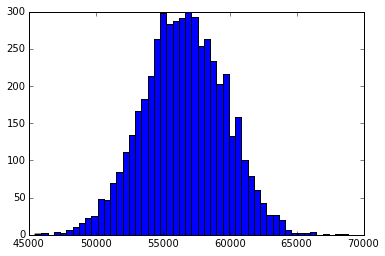

In [343]:
# Our model inputs
seo_conversion_rate = 0.02
seo_visits_per_day = 1000000

sem_conversion_rate = 0.07
sem_visits_per_day = 100000

other_conversion_rate = 0.03
other_visits_per_day = 650000

return_conversion_rate = 0.2
return_visits_per_day = 50000

orders_per_day = []
for random_day in range(5000):
    days_orders = 0
    
    sampled_seo_visits_per_day = np.random.normal(seo_visits_per_day, seo_visits_per_day * 0.1)
    seo_conversions = np.random.binomial(sampled_seo_visits_per_day, seo_conversion_rate)
    
    sampled_sem_visits_per_day = np.random.normal(sem_visits_per_day, sem_visits_per_day * 0.1)
    sem_conversions = np.random.binomial(sampled_sem_visits_per_day, sem_conversion_rate)
    
    sampled_other_visits_per_day = np.random.normal(other_visits_per_day, other_visits_per_day * 0.1)
    other_conversions = np.random.binomial(sampled_other_visits_per_day, other_conversion_rate)
    
    sampled_return_visits_per_day = np.random.normal(return_visits_per_day, return_visits_per_day * 0.1)
    return_conversions = np.random.binomial(sampled_return_visits_per_day, return_conversion_rate)
    
    orders_per_day.append(seo_conversions + sem_conversions + other_conversions + return_conversions)
    
plt.hist(orders_per_day, bins=50)
''

In [342]:
seo_conversion_rate * seo_visits_per_day + \
sem_conversion_rate * sem_visits_per_day + \
other_conversion_rate * other_visits_per_day + \
return_conversion_rate * return_visits_per_day

56500.0